In [4]:
import torch
import lightning as pl
from tabulate import tabulate
import matplotlib.pyplot as plt
import torchvision

from kornia import tensor_to_image
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, DeviceStatsMonitor, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.tuner import Tuner


In [5]:
class Args:
    def __init__(self, config):
        self.lr = config["lr"]
        self.working_dir_path = config["working_dir_path"]
        self.dataset_h5_path = config["dataset_h5_path"]
        self.hospitaldict_path = config["hospitaldict_path"]
        self.rseed = config["rseed"]
        self.train_ratio = config["train_ratio"]
        self.batch_size = config["batch_size"]
        self.freeze_layers = config["freeze_layers"]
        self.optimizer = config["optimizer"]
        self.lr = config["lr"]
        self.weight_decay = config["weight_decay"]
        self.momentum = config["momentum"]
        self.label_smoothing = config["label_smoothing"]
        self.max_epochs = config["max_epochs"]
        self.num_workers = config["num_workers"]
        self.accumulate_grad_batches = config["accumulate_grad_batches"]
        self.precision = config["precision"]
        self.disable_warnings = config["disable_warnings"]
        self.trim_data = config["trim_data"]
        self.pretrained = config["pretrained"]
        self.version = config["version"]
        self.augmentation = config["augmentation"]
        self.mixup = config["mixup"]

In [7]:
config = {
    "working_dir_path": ".",
    "dataset_h5_path": "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/dataset.h5",
    "hospitaldict_path": "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/hospitals-patients-dict.pkl",
    "rseed": 42,
    "train_ratio": 0.6,
    "batch_size": 16,
    "freeze_layers": None,
    "optimizer": "sgd",
    "lr": 0.0004,
    "weight_decay": 0.0001,
    "momentum": 0.9,
    "label_smoothing": 0.1,
    "max_epochs": 200,
    "num_workers": 0,
    "accumulate_grad_batches": 4,
    "precision": "32",
    "disable_warnings": True,
    "trim_data": None,
    "pretrained": False,
    "version": "nb",
    "augmentation": True,
    "mixup": False
}

args = Args(config)

In [8]:
pl.seed_everything(args.rseed)

Global seed set to 42


42

In [9]:
if torch.cuda.is_available():
    dev = torch.cuda.get_device_name()
    accelerator = "gpu"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
elif torch.backends.mps.is_built():
    accelerator="mps"
    mps_device = torch.device("mps")
    torch.set_default_device(f"{mps_device}")
else:
    dev = "cpu"

In [10]:
import warnings
if args.disable_warnings: 
    print("Warnings are DISABLED!\n\n")
    warnings.filterwarnings("ignore")
else:
    warnings.filterwarnings("default")

Warnings are DISABLED!




In [11]:
working_dir = args.working_dir_path
data_file = args.dataset_h5_path
libraries_dir = working_dir + "/libraries"

import sys
sys.path.append(working_dir)
sys.path.append("..")
from get_sets import get_sets, get_class_weights
from data_setup import HDF5Dataset, FrameTargetDataset, split_dataset, reduce_sets
from lightning_modules.LUSModelLightningModule import LUSModelLightningModule
from lightning_modules.LUSDataModule import LUSDataModule

# Data

In [12]:

sets, split_info = get_sets(
    args.rseed,
    data_file,
    args.hospitaldict_path,
    args.train_ratio,
    args.trim_data
)

lus_data_module = LUSDataModule(sets["train"], 
                                sets["test"],
                                sets["val"],
                                args.num_workers, 
                                args.batch_size,
                                args.mixup)


train_weight_tensor = get_class_weights(sets["train_indices"], split_info)


Serialized frame index map FOUND.

Loaded serialized data.


277 videos (58924 frames) loaded.
Split ratios: [0.6, 0.2, 0.2]

Serialized splits found, loading ...

Train size: 28869
Test size: 14712
Validation size: 15343
Class Weights:  [0.76437725 0.89068863 0.79067156 3.28654372]


In [13]:
train_dataloader = lus_data_module.train_dataloader()
train_dataloader

Use MixUp augmentation: False


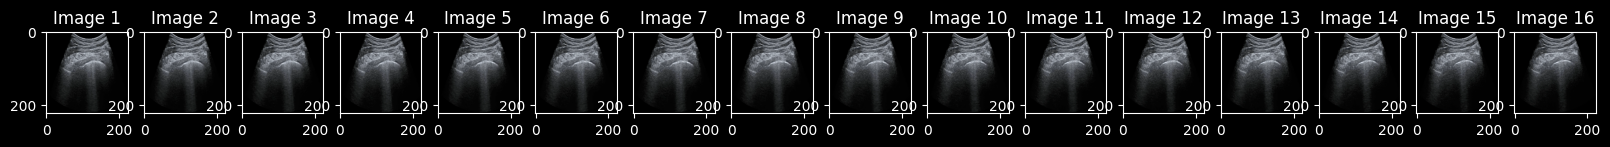

In [14]:
def show_single_batch(data_loader, batch_idx, win_size=(20, 20)):
    # Extract the specific batch by indexing the DataLoader
    for i, (imgs, labels) in enumerate(data_loader):
        if i == batch_idx:
            # Create a subplot for each image in the batch
            num_images = len(imgs)
            plt.figure(figsize=win_size)

            for j in range(num_images):
                plt.subplot(1, num_images, j + 1)
                plt.imshow(tensor_to_image(imgs[j]))  # Convert the tensor to an image
                plt.title(f"Image {j+1}")

            plt.show()
            break
# To display a specific batch (e.g., batch index 0) from the training DataLoader
show_single_batch(train_dataloader, batch_idx=6)

In [34]:
show_single_batch(train_dataloader, 1)

RuntimeError: Expected a 'mps:0' generator device but found 'cpu'

# Model

In [9]:
args_model = "botnet18"
hyperparameters = {
  "num_classes": 4,
  "optimizer": args.optimizer,
  "lr": args.lr,
  "batch_size": args.batch_size,
  "weight_decay": args.weight_decay,    
  "momentum": args.momentum,
  "label_smoothing": args.label_smoothing
}

freeze_layers = None
if args.pretrained:
    if args.freeze_layers:
        freeze_layers = args.freeze_layers
        
model = LUSModelLightningModule(model_name=args_model, 
                                hparams=hyperparameters,
                                class_weights=train_weight_tensor,
                                pretrained=args.pretrained,
                                freeze_layers=freeze_layers)

In [10]:
# -Logger configuration
version = f"V{args.version}" if args.version else "V1"
version = version.strip()

version = f"V{args.version}" if args.version else "V1"

name_version = f"_{version}"
name_trained = "_pretrained" if args.pretrained==True else ""
name_layer = f"_{args.freeze_layers}" if args.freeze_layers else ""
name_trimmed = "_trimmed" if args.trim_data else ""

model_name = f"{args_model}{name_version}{name_trained}{name_layer}{name_trimmed}/{args.optimizer}/ds_{args.train_ratio}_lr{args.lr}_bs{args.batch_size}"
logger = TensorBoardLogger("tb_logs", name=model_name, version=version)
# -Checkpointing
#   Checkpoints directory
checkpoint_dir = f"{working_dir}/checkpoints/{model_name}"
checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_dir, 
                                      save_top_k=1,
                                      mode="min",
                                      monitor="validation_loss",
                                      save_last=True,
                                      save_on_train_epoch_end=False,
                                      verbose=True,
                                      filename="{epoch}-{validation_loss:.4f}")


In [11]:
from lightning.pytorch.callbacks import LearningRateFinder
class FineTuneLearningRateFinder(LearningRateFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, *args, **kwargs):
        return

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.lr_find(trainer, pl_module)
            
LRFinder = FineTuneLearningRateFinder(milestones=(5, 10)) 


In [12]:
early_stop_callback = EarlyStopping(
    monitor='validation_loss',
    patience=10,
    strict=False,
    verbose=False,
    mode='min'
)


In [13]:
callbacks = [
            # DeviceStatsMonitor(),
            LearningRateMonitor(),
            early_stop_callback,
            checkpoint_callback,
            LRFinder
            ]

In [14]:
# Trainer args
trainer_args = {
    "max_epochs": args.max_epochs,
    "callbacks": callbacks,
    "precision": args.precision,
    "accumulate_grad_batches": args.accumulate_grad_batches,
    "logger": logger
}
# Trainer 
trainer = Trainer(**trainer_args,
                #   detect_anomaly=True,
                #   overfit_batches=0.01,
                #   val_check_interval=0.25,
                #   gradient_clip_val=0.1,
                    # benchmark=True,
                    accelerator=accelerator,
                    default_root_dir = checkpoint_dir)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
 trainer.fit(model, lus_data_module)


  | Name            | Type               | Params
-------------------------------------------------------
0 | model           | BotNet             | 8.1 M 
1 | train_criterion | CrossEntropyLoss   | 0     
2 | test_criterion  | CrossEntropyLoss   | 0     
3 | transform       | DataAugmentation   | 0     
4 | train_f1        | MulticlassF1Score  | 0     
5 | val_f1          | MulticlassF1Score  | 0     
6 | test_f1         | MulticlassF1Score  | 0     
7 | train_acc       | MulticlassAccuracy | 0     
8 | val_acc         | MulticlassAccuracy | 0     
9 | test_acc        | MulticlassAccuracy | 0     
-------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.258    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Use MixUp augmentation: True


Training: 0it [00:00, ?it/s]

In [ ]:
model.hparams

"freeze_layers": None
"hparams":       {'num_classes': 4, 'optimizer': 'sgd', 'lr': 0.0004, 'batch_size': 16, 'weight_decay': 0.0001, 'momentum': 0.9, 'label_smoothing': 0.1}
"model_name":    betnet18
"pretrained":    False